# Importing libraries and data

In [60]:
import os
import glob

TRAINING_ONLY = True

In [61]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [62]:
dataset_path = '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2'

audio_path = os.path.join(dataset_path, 'respiratory_sound_database','Respiratory_Sound_Database', 'audio_and_txt_files')
audio_files = glob.glob(os.path.join(audio_path, '**/*.wav'), recursive=True)

# print(glob.glob(os.path.join(dataset_path, '*'), recursive=True))

print(f"Found {len(audio_files)} audio files.")

Found 920 audio files.


# EDA

# Data Preparation

In [63]:
import os
import glob
import random
import numpy as np
import pandas as pd
import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [64]:
patient_diagnosis = os.path.join(dataset_path, 'demographic_info.txt')
col_names = ['patient_id', 'age', 'sex', 'adult_bmi', 'child_weight', 'child_height']
df_demo = pd.read_csv(patient_diagnosis, sep=" ", header=None, names=col_names)


# Load the disease diagnosis information
diagnosis_mapping = {}
diagnosis_file = os.path.join(dataset_path, 'demographic_info.txt')
with open(diagnosis_file, 'r') as f:
    for line in f:
        parts_diag = line.strip().split()
        if len(parts_diag) >= 2:
            patient_id = parts_diag[0]
            diagnosis = parts_diag[1]
            diagnosis_mapping[patient_id] = diagnosis

In [65]:
patient_diagnosis = os.path.join(dataset_path, 'respiratory_sound_database','Respiratory_Sound_Database', 'patient_diagnosis.csv')
df_diag = pd.read_csv(patient_diagnosis, header=None, names=['patient_id', 'diagnosis'])
print(df_diag['diagnosis'].value_counts())

diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64


In [66]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    """
    Extract audio features including MFCCs, spectral centroid,
    zero crossing rate, spectral bandwidth, and chroma features.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    if y.size == 0:
        print(f"File {file_path} is empty.")
        return None

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Spectral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)
    spec_centroid_std = np.std(spec_centroid)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Spectral bandwidth
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bandwidth_mean = np.mean(spec_bandwidth)
    spec_bandwidth_std = np.std(spec_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Combine features into a dictionary
    features = {}
    for i in range(n_mfcc):
        features[f'mfcc_{i+1}_mean'] = mfcc_mean[i]
        features[f'mfcc_{i+1}_std'] = mfcc_std[i]

    features['spec_centroid_mean'] = spec_centroid_mean
    features['spec_centroid_std'] = spec_centroid_std
    features['zcr_mean'] = zcr_mean
    features['zcr_std'] = zcr_std
    features['spec_bandwidth_mean'] = spec_bandwidth_mean
    features['spec_bandwidth_std'] = spec_bandwidth_std

    for i in range(chroma.shape[0]):
        features[f'chroma_{i+1}_mean'] = chroma_mean[i]
        features[f'chroma_{i+1}_std'] = chroma_std[i]

    return features

In [67]:
# Augmentation functions (no redefinition of time_stretch)
def pitch_shift(y, sr, n_steps=4):
    """Pitch shift the audio signal by n_steps semitones."""
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    """Inject random noise into the audio signal."""
    noise = np.random.randn(len(y)) * noise_level
    return y + noise

def change_volume(y, gain=1.5):
    """Increase or decrease the volume by a certain gain factor."""
    return y * gain

def apply_random_augmentation(y, sr):
    """Randomly apply one of the augmentations."""
    augmentation_type = random.choice(["time_stretch", "pitch_shift", "add_noise", "change_volume", None])

    if augmentation_type == "time_stretch":
        rate = random.uniform(0.8, 1.5)
        y = librosa.effects.time_stretch(y, rate=rate)
    elif augmentation_type == "pitch_shift":
        y = pitch_shift(y, sr, n_steps=random.randint(-5, 5))
    elif augmentation_type == "add_noise":
        y = add_noise(y, noise_level=random.uniform(0.001, 0.01))
    elif augmentation_type == "change_volume":
        y = change_volume(y, gain=random.uniform(0.5, 2.0))

    return y

In [68]:
feature_list = []
labels = []

for file in audio_files:
    feats = extract_features(file)
    if feats is None:
        continue
    feature_list.append(feats)

    # Extract patient ID from the file name (first part)
    file_name = os.path.basename(file)
    parts = file_name.split('_')
    if len(parts) >= 1:
        patient_id = parts[0]
        diagnosis_row = df_diag[df_diag['patient_id'] == int(patient_id)]

        if not diagnosis_row.empty:
            diagnosis = diagnosis_row['diagnosis'].values[0]

            if diagnosis == "Healthy":
                label = "healthy"
            elif diagnosis == 'COPD':
              label = 'COPD'
            elif diagnosis == 'LRTI':
              label = 'LRTI'
            elif diagnosis == 'URTI':
              label = 'URTI'
            elif diagnosis == 'Bronchiectasis':
              label = 'Bronchiectasis'
            elif diagnosis == 'Pneumonia':
              label = 'Pneumonia'
            elif diagnosis == 'Bronchiolitis':
              label = 'Bronchiolitis'
            else:
                label = "unknown"
        else:
            label = "unknown"
            print(f"Warning: Missing diagnosis for patient {patient_id}. Label set to 'unknown'.")

    else:
        label = "unknown"

    labels.append(label)

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [101]:
# Create DataFrame from features and labels
df_features = pd.DataFrame(feature_list)
df_features['label'] = labels

df_features = df_features[df_features['label'] != 'unknown']

# Debug: Check label distribution before filtering
print("Feature DataFrame shape:", df_features.shape)
print("-"*50)
print(df_features['label'].value_counts())
# print("-"*50)
# print(df_features.head())

Feature DataFrame shape: (919, 57)
--------------------------------------------------
label
COPD              793
Pneumonia          37
healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Name: count, dtype: int64
['COPD' 'healthy' 'Pneumonia' 'URTI' 'Bronchiectasis' 'Bronchiolitis'
 'LRTI']


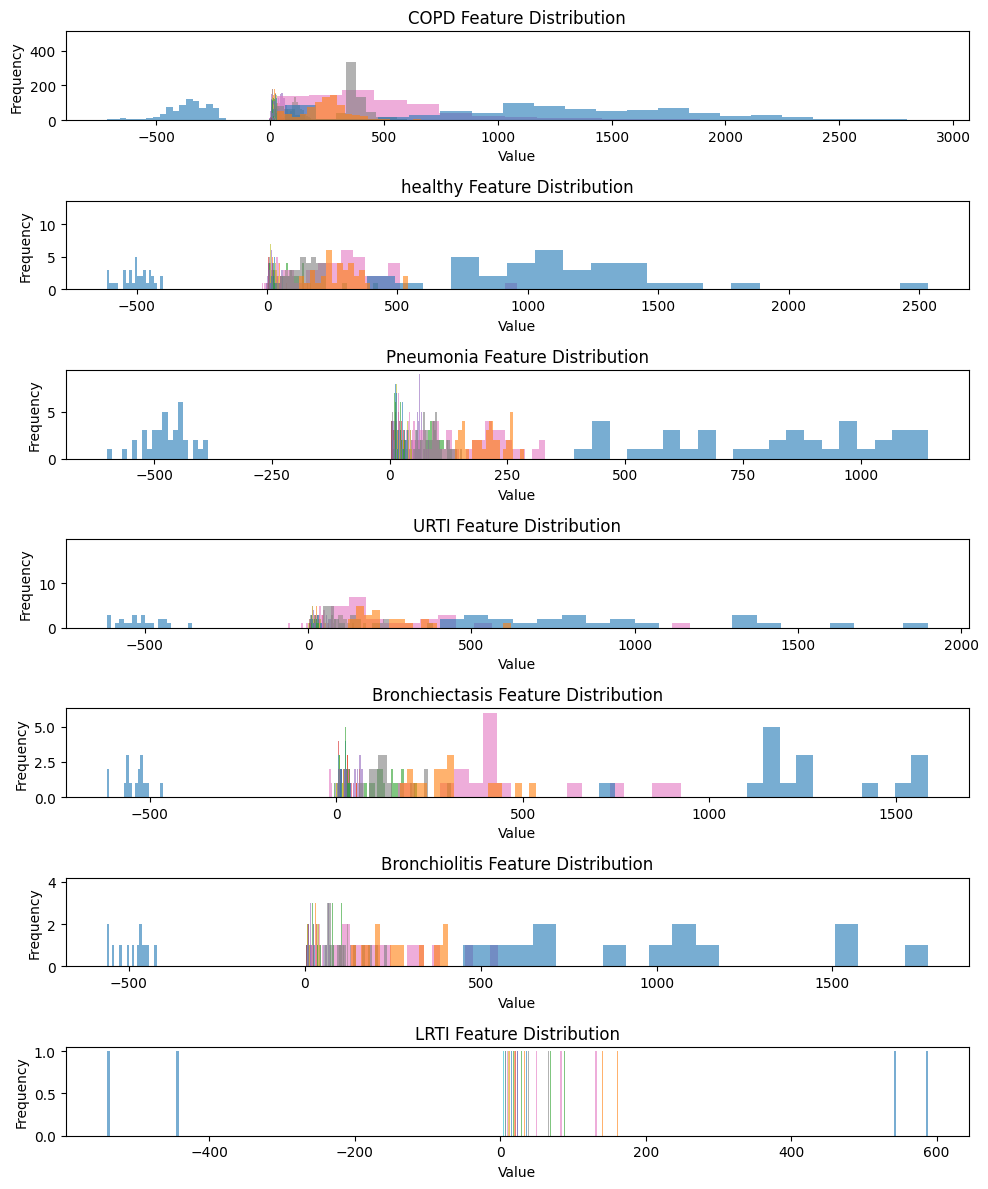

In [120]:
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(10, 12))

for i, label in enumerate(labels):
    label_data = df_features[df_features['label'] == label]
    ax = axes[i] if len(labels) > 1 else axes
    ax.set_title(f'{label} Feature Distribution')

    # Plot histograms for MFCC mean and std features
    for feature in label_data.columns[:-1]:
        ax.hist(label_data[feature], bins=20, alpha=0.6, label=feature)

    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")
    # ax.legend()

plt.tight_layout()
plt.show()

In [70]:
target_samples = 500

# Separate the data by label
df_balanced = pd.DataFrame()

for label in df_features['label'].unique():
    class_data = df_features[df_features['label'] == label]

    if class_data.shape[0] < target_samples:
        oversampled_data = class_data.sample(target_samples, replace=True)
        df_balanced = pd.concat([df_balanced, oversampled_data], axis=0)
    else:
        df_balanced = pd.concat([df_balanced, class_data], axis=0)

# Shuffle the dataset to mix the oversampled data
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Check the new label distribution
print("Balanced DataFrame shape:", df_balanced.shape)
print("-"*50)
print(df_balanced['label'].value_counts())

Balanced DataFrame shape: (3793, 57)
--------------------------------------------------
label
COPD              793
Pneumonia         500
Bronchiectasis    500
healthy           500
LRTI              500
Bronchiolitis     500
URTI              500
Name: count, dtype: int64


In [105]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = df_features.drop('label', axis=1)
y = df_features['label']
y_encoded = le.fit_transform(y)
feature_columns = [col for col in df_features.columns if col != 'label']

X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop('label', axis=1),
                                                    df_balanced['label'],
                                                    test_size=0.2, random_state=42)

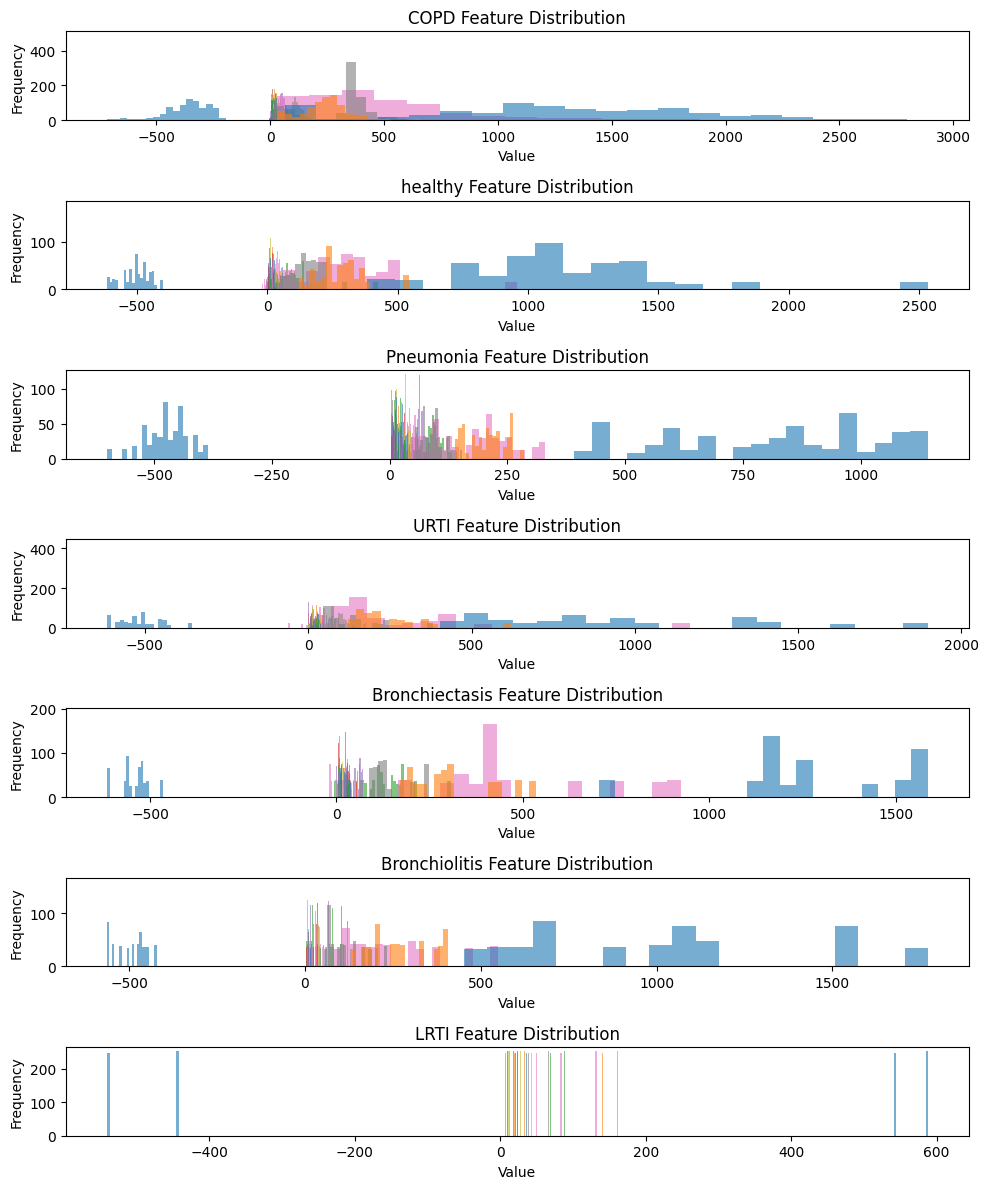

In [122]:
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(10, 12))

for i, label in enumerate(labels):
    label_data = df_balanced[df_balanced['label'] == label]
    ax = axes[i] if len(labels) > 1 else axes
    ax.set_title(f'{label} Feature Distribution')

    # Plot histograms for MFCC mean and std features
    for feature in label_data.columns[:-1]:
        ax.hist(label_data[feature], bins=20, alpha=0.6, label=feature)

    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")
    # ax.legend()

plt.tight_layout()
plt.show()

# Model Building

## RandomForest Classification

In [81]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [73]:
# Train a Random Forest classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=4,
    max_features=0.5,
    bootstrap=True,
    random_state=42
)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=0.5, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=50, random_state=42)

In [74]:
# Make predictions and evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 99.60%


In [82]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("-"*50)

# Classification Report
cr = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:")
print(cr)
print("-"*50)

# Perform 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Confusion Matrix:
[[100   0   0   0   0   0   0]
 [  0  83   0   0   0   0   0]
 [  1   0 159   0   1   1   0]
 [  0   0   0 102   0   0   0]
 [  0   0   0   0 105   0   0]
 [  0   0   0   0   0 101   0]
 [  0   0   0   0   0   0 106]]
--------------------------------------------------
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.99      1.00      1.00       100
 Bronchiolitis       1.00      1.00      1.00        83
          COPD       1.00      0.98      0.99       162
          LRTI       1.00      1.00      1.00       102
     Pneumonia       0.99      1.00      1.00       105
          URTI       0.99      1.00      1.00       101
       healthy       1.00      1.00      1.00       106

      accuracy                           1.00       759
     macro avg       1.00      1.00      1.00       759
  weighted avg       1.00      1.00      1.00       759

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.90217391 0.90217391 0.92391304 0.9076087  0.87978142]
Mean CV score: 0.9031301971964837
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


## SVM

In [83]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [84]:
# Create a pipeline that first scales the data then trains an SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ('svc', SVC(
        kernel='linear',
        probability=True,
        C=0.1,
        random_state=42
        ))
])

# Define a grid of hyperparameters to search over
param_grid = {
    # 'svc__C': [0.1, 1, 10, 100],
    'svc__C': [0.1, 1, 10]
    # 'svc__gamma': [0.001, 0.01, 0.1, 1],
}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'svc__C': 10}
Best cross validation accuracy: 0.9930790937413345


In [85]:
# Predict on the test set and evaluate accuracy
y_pred_svm = grid_search.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
svm = grid_search.best_estimator_
print(f"SVM Test Accuracy: {accuracy_svm*100:.2f}%")

SVM Test Accuracy: 99.74%


In [86]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred_svm, target_names=le.classes_)
print("Classification Report:")
print(cr)

# Evaluate the best SVM pipeline using cross-validation on the training set
cv_scores_svm = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print("SVM Cross-validation scores:", cv_scores_svm)
print("Mean SVM CV score:", cv_scores_svm.mean())

Confusion Matrix:
[[100   0   0   0   0   0   0]
 [  0  83   0   0   0   0   0]
 [  1   1 160   0   0   0   0]
 [  0   0   0 102   0   0   0]
 [  0   0   0   0 105   0   0]
 [  0   0   0   0   0 101   0]
 [  0   0   0   0   0   0 106]]
Classification Report:
                precision    recall  f1-score   support

Bronchiectasis       0.99      1.00      1.00       100
 Bronchiolitis       0.99      1.00      0.99        83
          COPD       1.00      0.99      0.99       162
          LRTI       1.00      1.00      1.00       102
     Pneumonia       1.00      1.00      1.00       105
          URTI       1.00      1.00      1.00       101
       healthy       1.00      1.00      1.00       106

      accuracy                           1.00       759
     macro avg       1.00      1.00      1.00       759
  weighted avg       1.00      1.00      1.00       759

SVM Cross-validation scores: [0.99176277 0.99341021 0.99505766 0.99011532 0.9950495 ]
Mean SVM CV score: 0.993079093741334

## Ensemble

In [87]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# base_learners = [
#     ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)),
#     ('svm', SVC(kernel='linear', C=0.1, random_state=42))
# ]

# stack_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
# stack_model.fit(X_train, y_train)

# y_pred_stack = stack_model.predict(X_test)
# accuracy_stack = accuracy_score(y_test, y_pred_stack)
# print(f"Stacking Model Test Accuracy: {accuracy_stack*100:.2f}%")

Stacking Model Test Accuracy: 100.00%


In [88]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble classifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[('rf', clf), ('svm', svm)],
    voting='soft',
    weights=[3, 2]
)

# Train the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Predict on the test set and evaluate accuracy
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Test Accuracy: {accuracy_ensemble*100:.2f}%")

Ensemble Model Test Accuracy: 100.00%


# Try out

In [92]:
def predict_lung_cancer_probability(wav_file, ensemble_model, feature_columns, label_encoder):
    # Extract features using the same function as for training
    feats = extract_features(wav_file)
    if feats is None:
        print(f"Error extracting features from {wav_file}.")
        return None

    input_data = pd.DataFrame([feats])
    input_data = input_data.reindex(columns=feature_columns, fill_value=0)

    # Predict probabilities using the ensemble model

    probas = ensemble_model.predict_proba(input_data)
    diseased_index = np.where(label_encoder.classes_ == 'Bronchiectasis')[0][0]
    probability_diseased = probas[0, diseased_index]
    return probability_diseased

In [103]:
def predict(wav_file, ensemble_model, feature_columns, label_encoder, top_n=3):
    # Extract features using the same function as for training
    feats = extract_features(wav_file)
    if feats is None:
        print(f"Error extracting features from {wav_file}.")
        return None

    input_data = pd.DataFrame([feats])
    input_data = input_data.reindex(columns=feature_columns, fill_value=0)

    probas = ensemble_model.predict_proba(input_data)
    probas_sorted_indices = np.argsort(probas[0])[::-1]
    top_diseases = []

    for i in range(top_n):
        disease_index = probas_sorted_indices[i]
        disease_label = label_encoder.classes_[disease_index]
        disease_probability = probas[0, disease_index]
        top_diseases.append((disease_label, disease_probability))

    return top_diseases


In [93]:
wav_tests = glob.glob('/content/test/*.wav')
feature_columns = df_features.drop("label", axis=1).columns

In [96]:
for test in wav_tests:
    probability = predict_lung_cancer_probability(test, ensemble_model, feature_columns, le)
    if probability is not None:
        print(f"Probability of lung cancer: {probability*100:.2f}%")

Probability of lung cancer: 3.55%
Probability of lung cancer: 1.15%
Probability of lung cancer: 4.57%


In [111]:
for test in wav_tests:
    probability = predict(wav_file=test,
                                       ensemble_model=ensemble_model,
                                       feature_columns=feature_columns,
                                       label_encoder=le,
                                       top_n=7)
    if probability is not None:
        print(f"Top 3 disease probabilities for {test}:")
        for disease, prob in probability:
            print(f"{disease}: {prob * 100:.2f}%")


Top 3 disease probabilities for /content/test/M_0398_12y5m_1.wav:
COPD: 77.52%
URTI: 11.95%
Bronchiolitis: 4.76%
Bronchiectasis: 3.55%
healthy: 2.23%
Pneumonia: 0.00%
LRTI: 0.00%
Top 3 disease probabilities for /content/test/M_0025_11y10m_1.wav:
COPD: 84.92%
Pneumonia: 6.78%
URTI: 5.95%
healthy: 1.20%
Bronchiectasis: 1.15%
LRTI: 0.00%
Bronchiolitis: 0.00%
Top 3 disease probabilities for /content/test/M_0014_11y7m_1.wav:
COPD: 77.60%
Bronchiolitis: 10.63%
URTI: 4.80%
Bronchiectasis: 4.57%
healthy: 2.40%
Pneumonia: 0.00%
LRTI: 0.00%


In [95]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap your ensemble classifier with calibration
calibrated_ensemble = CalibratedClassifierCV(ensemble_model, cv=5, method='isotonic')
calibrated_ensemble.fit(X_train, y_train)

# Now predict probabilities on new samples
for test in wav_tests:
    probability = predict_lung_cancer_probability(test, calibrated_ensemble, feature_columns, le)
    if probability is not None:
        print(f"Calibrated probability of lung cancer: {probability*100:.2f}%")

Calibrated probability of lung cancer: 0.00%
Calibrated probability of lung cancer: 0.00%
Calibrated probability of lung cancer: 0.00%
